In [1]:
import pandas as pd
import numpy as np

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from nltk.corpus import stopwords
import nltk


In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [94]:
from matplotlib import pyplot as plt

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [3]:
tweet_df = pd.read_csv('../data/tweet_df.csv')
clusters = pd.read_csv('../../cc_election_cleaning/clusters_with_names_dec4.csv')

In [4]:
name_list = tweet_df['full_name'].unique()

In [5]:
def match_names(name, names_list):
    match, score = process.extractOne(name, names_list, scorer=fuzz.token_sort_ratio)
    return match if score >= 90 else name

In [6]:
def preprocess_text(text, stopwords):
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text.lower())  
    text = re.sub(r'[^\w\s]', '', text)  
    tokens = [word for word in text.split() if word not in stopwords]  
    return ' '.join(tokens)

In [7]:
clusters['twitter_name'] = clusters['matched_name'].apply(lambda x: match_names(x, name_list.tolist()))

In [8]:
fc = clusters[['twitter_name','kmode_cluster']]

In [9]:
tweet_fc = tweet_df.merge(fc, left_on='full_name', right_on='twitter_name', how='left')

In [10]:
tweet_fc = tweet_fc[['date','text','twitter_name','kmode_cluster']]

In [11]:
tweet_fc['date'] = pd.to_datetime(tweet_fc['date'])
tweet_fc['month'] = tweet_fc['date'].dt.to_period('M')

C:\Users\samtg\AppData\Local\Temp\ipykernel_23680\3301695755.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tweet_fc['month'] = tweet_fc['date'].dt.to_period('M')


In [12]:
tweet_fc.dropna(subset=['twitter_name'], inplace=True)

tf_idf

In [147]:
df = tweet_fc.copy()

In [148]:
df = df[df['date'] < '2021-07-01']

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samtg\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
standard_stopwords = set(stopwords.words('english'))
custom_stopwords = {'us','day','amp','thank','new','today','us','im','get','council','district','need','great',
                    'work','nyc','city','join','support','office','proud','time','see','public','people','happy',
                    'make','help','many','thanks','first','must','year','one','communities','together','last',
                    'like','please','much','york','yorkers','every','de','colleagues','event','forward','love''members',
                     'bronx','brooklyn','manhattan','queens','staten','island','community','important','team','week',
                      'love','continue','joined','free','tomorrow', 'years','know', 'vote','voter','voters', 'lets','back','congratulations',
                       'campaign','endorsement', 'neighbors','honored','keep','also','good','right','sign',
                        'local', 'look', 'still','working', 'look', 'looking', 'congressman', '15','yes','go',
                         'south','hunts','point','1','everyone','come','stand','way','cant','well','open','would',
                         'always','dont','better','take','workers','vaccine','elmhurst','holden','sure'} 
all_stopwords = standard_stopwords.union(custom_stopwords)

In [149]:
df['processed_text'] = df['text'].apply(lambda x: preprocess_text(x, all_stopwords))

In [150]:
all_words = ' '.join(df['processed_text']).split()
word_freq = Counter(all_words)
print(word_freq.most_common(20))

[('fight', 903), ('justice', 703), ('housing', 545), ('pandemic', 543), ('health', 499), ('women', 480), ('families', 476), ('safe', 472), ('park', 462), ('black', 442), ('food', 441), ('next', 432), ('family', 417), ('fighting', 416), ('excited', 412), ('want', 399), ('state', 398), ('may', 396), ('voting', 392), ('call', 390)]


In [151]:
member_texts = df.groupby('twitter_name')['processed_text'].apply(lambda x: ' '.join(x)).reset_index()

In [152]:
tfidf_vectorizer = TfidfVectorizer()

In [153]:
tfidf_matrix = tfidf_vectorizer.fit_transform(member_texts['processed_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=member_texts['twitter_name'])

In [154]:
top_n = 10 
characteristic_words = {}
for cluster in tfidf_df.index:
    sorted_words = tfidf_df.loc[cluster].sort_values(ascending=False).head(top_n)
    characteristic_words[cluster] = sorted_words.index.tolist()

In [155]:
characteristic_words_df = pd.DataFrame(characteristic_words).T

Not telling us much, lets look at specific categories and then sentiments 

In [170]:
cop_words = ['cop', 'police', 'nypd','policing','public safety','plainclothes']
crime = ['criminal','crime','violence','gun','shoot']
transit_words = ['bus','bus rider','train','subway','mta','transit','fare']
bike_words = ['bike','bike lane','protected bike lane','cycle','cyclist']
housing_words = ['housing','rent','zoning','section 8','voucher']
landlord_words = ['landlord']
tenant_words = ['tenant']
educ_words = ['education','teacher','school','student','classroom']
dsa = ['dsa','socialist']
blas = ['blasio','deblasio']
jail = ['jail','prison','rikers','incarceration']
palestine = ['palestine']
lgbtq = ['lgbtq','trans','transsexual','gay','lesbian','queer','bisexual']
covid = ['covid','coronavirus','pandemic']
vaccine = ['vaccine','vaccination']
black = ['black','african american','african-american','bipoc']
immigrant = ['immigrant','immigration','migrant']

In [129]:
def make_topic_tweets(df, topic):
    df_tweets = df[df['text'].str.contains('|'.join(topic), case=False)]
    df_topic_tweets = df_tweets[df_tweets['date'] < '2021-07-01']
    return df_topic_tweets

In [172]:
cop_tweets = make_topic_tweets(tweet_fc, cop_words)
crime_tweets = make_topic_tweets(tweet_fc, crime)
transit_tweets = make_topic_tweets(tweet_fc, transit_words)
bike_tweets = make_topic_tweets(tweet_fc, bike_words)
housing_tweets = make_topic_tweets(tweet_fc, housing_words)
landlord_tweets = make_topic_tweets(tweet_fc, landlord_words)
tenant_tweets = make_topic_tweets(tweet_fc, tenant_words)
educ_tweets = make_topic_tweets(tweet_fc, educ_words)
dsa_tweets = make_topic_tweets(tweet_fc, dsa)
blas_tweets = make_topic_tweets(tweet_fc, blas)
jail_tweets = make_topic_tweets(tweet_fc, jail)
palestine_tweets = make_topic_tweets(tweet_fc,palestine)
lgbtq_tweets = make_topic_tweets(tweet_fc,lgbtq)
covid_tweets = make_topic_tweets(tweet_fc,covid)
vaccine_tweets = make_topic_tweets(tweet_fc,vaccine)
black_tweets = make_topic_tweets(tweet_fc,black)
immigrant_tweets = make_topic_tweets(tweet_fc,immigrant)

In [173]:
for_sentiment= [cop_tweets,crime_tweets,bike_tweets,landlord_tweets,tenant_tweets,dsa_tweets,blas_tweets,jail_tweets,palestine_tweets,lgbtq_tweets,vaccine_tweets,black_tweets,immigrant_tweets]
for_sentiment_names = ['cop','crime','bike','landlord','tenant','dsa','blas','jail','palestine','lgbtq','vaccine','black','immigrant']
for_tfidf = [cop_tweets,crime_tweets,transit_tweets,housing_tweets,educ_tweets,dsa_tweets,blas_tweets,jail_tweets,lgbtq_tweets,covid_tweets,black_tweets,immigrant_tweets]
for_tfidf_names = ['cop','crime','transit','housing','educ','dsa','blas','jail','lgbtq','covid','black','immigrant']

In [22]:
cop_stops = ['nypd','police','cop','cops','policing','public safety','safety','officer','coney','safe','officers','violence',
             'ty','12']
all_stops_with_cop = all_stopwords.union(cop_stops)

In [23]:
cop_tweets['processed_text'] = cop_tweets['text'].apply(lambda x: preprocess_text(x, all_stops_with_cop))

In [111]:
cluster_texts = cop_tweets.groupby('kmode_cluster')['processed_text'].apply(lambda x: ' '.join(x)).reset_index()

In [112]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_texts['processed_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=cluster_texts['kmode_cluster'])

In [113]:
top_n = 10 
characteristic_words = {}
for cluster in tfidf_df.index:
    sorted_words = tfidf_df.loc[cluster].sort_values(ascending=False).head(top_n)
    characteristic_words[cluster] = sorted_words.index.tolist()

characteristic_words_df = pd.DataFrame(characteristic_words).T

In [114]:
characteristic_words_df

,0,1,2,3,4,5,6,7,8,9
0.0,black,justice,housing,ccrb,hearing,committee,development,reform,invest,george
1.0,criminals,issues,via,neighborhoods,ncos,hate,another,maspeth,veterans,antipolice
2.0,hate,young,happen,guy,feel,floyd,news,family,multilingual,responsible
3.0,black,budget,health,invest,brown,services,students,housing,justice,schools
4.0,civic,hate,attacks,residents,action,prepared,fresh,association,food,anyone


Lets pull out some example tweets

In [118]:
pd.set_option('display.max_colwidth', None)

In [115]:
cluster_three = cop_tweets[cop_tweets['kmode_cluster'] == 3]

In [120]:
search_words = ['landlord']
found_tweets = tweet_fc[tweet_fc['text'].str.contains('|'.join(search_words), case=False)]

In [121]:
found_tweets[['text','twitter_name']].sample(10)

,text,twitter_name
94981,I’m proud to have hosted this town hall for landlords in and out of my district. Right now my District and areas throughout New York are facing an influx of scammers who target small landlords. They pay one month’s rent and never pay again. They bring in more tenants than agreed… https://t.co/KymAfkorcI,Vickie Paladino
5868,Today the Committee on Civil and Human Rights held a hearing regarding the controversial Intro 632 bill which would make it illegal for landlords to conduct criminal background checks on prospective tenants. (1/4) https://t.co/Q71uYHx0Se,Vickie Paladino
21479,Proud to be cosponsoring this legislation alongside @PiSanchezNYC. Landlords NEED to be held accountable if their buildings get repeat inspections because of tenant complaints. https://t.co/SpFwCgr3Ux,Pierina Ana Sanchez
39234,The Community Clinic for Tenants wants to make sure that you know your rights against landlord harassment!\n\nNYC already faces a housing crisis; we should not be getting pushed out of the homes we have.\n\nJoin us in this workshop to learn how you can assert your legal rights. https://t.co/MCdv7YpmVg,Carmen N. De La Rosa
108844,"As a tenant lawyer who spent many hours in Bronx Housing Court, I saw the dirty tactics landlord-lawyers used to try to evict tenants. Also saw the difference in outcomes when tenants had a lawyer. Joining @ShaunAbreu @PiSanchezNYC in saying: no cases unless tenants are defended.",Oswald Feliz
4790,missed the day we were meant to post but…\n\nlandlords shouldn’t be able to evict &amp; bosses shouldn’t be able to fire at-will. \n\nI’m proud to be in @nycdsa where @JuliaCarmel__ and @tiffany_caban are fighting for just cause for workers &amp; tenants\n\nhttps://t.co/Ia2fx9Fiuh,Tiffany Cabán
76871,"Are you a tenant behind on rent due to COVID-19, or a landlord with tenants who owe back rent? Apply now for the New York State Emergency Rental Assistance Program (ERAP), with the help of @NHSJamaica! For more information, visit https://t.co/Sg10iltjrI. https://t.co/DDRowxT37q",Adrienne E. Adams
144643,"The Department of Buildings is hosting a ""How To Counter Harassment: Know Your Rights"" seminar tomorrow on what you can do if your landlord has created a hazardous environment in your home. Register here: \n\nhttps://t.co/c1KK7tYGsE",Shahana K. Hanif
116754,"Facial recognition + biometric identifiers often misidentify people of color, women + non-binary people, and can be used by landlords to harass + evict tenants. I rallied today ahead of my bill’s hearing to limit use of biometrics in residential settings. #banthescan https://t.co/vcS42poE8k",Carlina Rivera
90379,"Source of income discrimination is illegal in New York City, which was strengthened by my recent law to expand protected tenants. Landlords need to follow the law.\n\nWe also need to add more resources to enforcement, which we’ve been fighting for since 2019.",Keith Powers


Cop Sentiment 

In [76]:
from sklearn.decomposition import PCA

In [101]:
cop_tweets['vader_sentiment'] = cop_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
transit_tweets['vader_sentiment'] = transit_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
bike_tweets['vader_sentiment'] = bike_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
housing_tweets['vader_sentiment'] = housing_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
#educ_tweets['vader_sentiment'] = educ_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
#union_tweets['vader_sentiment'] = union_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
dsa_tweets['vader_sentiment'] = dsa_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
blas_tweets['vader_sentiment'] = blas_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
jail_tweets['vader_sentiment'] = jail_tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [136]:
def get_sentiment(df):
    df['vader_sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
    return df

In [25]:
cop_tweets['pp_vader_sentiment'] = cop_tweets['processed_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [ ]:
member_cop_tweets = cop_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()
member_transit_tweets = transit_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()
member_bike_tweets = bike_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()
member_housing_tweets = housing_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()
#member_educ_tweets = educ_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()
#member_union_tweets = union_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()
member_dsa_tweets = dsa_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()
member_blas_tweets = blas_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()
member_jail_tweets = jail_tweets.groupby('twitter_name')['vader_sentiment'].mean().reset_index()

In [102]:
datasets = [cop_tweets, transit_tweets, bike_tweets, housing_tweets, dsa_tweets, blas_tweets, jail_tweets]
names = ['cop', 'transit', 'bike', 'housing',  'dsa', 'blas', 'jail']

In [103]:
def get_vader_and_count(df,name:str):
    member_df = df.groupby('twitter_name', as_index=False)['vader_sentiment'].mean()
    member_df['count'] = df['twitter_name'].value_counts().reindex(member_df['twitter_name']).values
    member_df.columns = ['twitter_name',f'{name}_vader_sentiment',f'{name}_count']
    return member_df

In [174]:
all_members = None  
for df, name in zip(for_sentiment, for_sentiment_names): 
    df = get_sentiment(df)
    member_df = get_vader_and_count(df, name)  
    if all_members is None:
        all_members = member_df  
    else:
        all_members = all_members.merge(member_df, on='twitter_name', how='outer') 


In [175]:
# replace Nan with 0
all_members = all_members.fillna(0)

In [176]:
all_members.head()

,twitter_name,cop_vader_sentiment,cop_count,crime_vader_sentiment,crime_count,bike_vader_sentiment,bike_count,landlord_vader_sentiment,landlord_count,tenant_vader_sentiment,...,palestine_vader_sentiment,palestine_count,lgbtq_vader_sentiment,lgbtq_count,vaccine_vader_sentiment,vaccine_count,black_vader_sentiment,black_count,immigrant_vader_sentiment,immigrant_count
0,Adrienne E. Adams,0.151420,51.0,-0.363535,26.0,-0.64860,1.0,0.000000,0.0,0.372567,...,0.0000,0.0,0.073114,7.0,0.309704,26.0,0.169675,20.0,0.474575,8.0
1,Alexa Avilés,0.117637,59.0,-0.270168,22.0,0.21130,7.0,-0.388533,3.0,0.189750,...,0.8211,1.0,0.515422,37.0,0.152087,38.0,0.401573,15.0,0.309887,54.0
2,Althea V. Stevens,0.098089,9.0,-0.358760,5.0,0.00000,0.0,0.000000,0.0,0.000000,...,0.0000,0.0,0.696575,4.0,0.000000,0.0,0.499540,5.0,0.000000,0.0
3,Amanda Farías,-0.025725,4.0,-0.187100,3.0,0.89775,2.0,0.000000,0.0,0.440400,...,0.0000,0.0,0.581190,10.0,0.345300,4.0,-0.138200,3.0,0.448433,3.0
4,Ari Kagan,0.156270,23.0,-0.410600,18.0,0.00000,0.0,0.000000,0.0,0.819800,...,0.0000,0.0,0.202000,2.0,0.694360,5.0,0.000000,0.0,0.600800,5.0


In [26]:
ct_centiment = cop_tweets.groupby('kmode_cluster')['pp_vader_sentiment'].mean().reset_index(name='pp_vader_mean')
ct_centiment['vader_mean'] = cop_tweets.groupby('kmode_cluster')['vader_sentiment'].mean().values
ct_centiment

,kmode_cluster,pp_vader_mean,vader_mean
0,0.0,-0.036439,0.091676
1,1.0,-0.108222,0.108157
2,2.0,-0.047427,0.162272
3,3.0,-0.043266,0.102254
4,4.0,0.052521,0.284464


In [69]:
cop_tweets['processed_text'] = cop_tweets['text'].apply(lambda x: preprocess_text(x, all_stops_with_cop))

In [70]:
cop_tweets_person_text = cop_tweets.groupby('twitter_name')['processed_text'].apply(lambda x: ' '.join(x)).reset_index()

In [73]:
vectorizer = TfidfVectorizer()
cop_tfidf_matrix = vectorizer.fit_transform(cop_tweets_person_text['processed_text'])

In [ ]:
pca = PCA(n_components=3)
cop_tfidf_pca = pca.fit_transform(cop_tfidf_matrix.toarray())
cop_features = pd.DataFrame(cop_tfidf_pca, columns=['cop_pca1', 'cop_pca2', 'cop_pca3'])
cop_features['twitter_name'] = cop_tweets_person_text['twitter_name']

In [86]:
def tf_idf_pca_topic(df, topic_label):
    df['processed_text'] = df['text'].apply(lambda x: preprocess_text(x, all_stopwords))
    df_person_text = df.groupby('twitter_name')['processed_text'] \
                       .apply(lambda x: ' '.join(x)) \
                       .reset_index()
    
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df_person_text['processed_text'])
    pca = PCA(n_components=3)
    tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())
    features = pd.DataFrame(tfidf_pca, 
                            columns=[f'{topic_label}_pca1', 
                                     f'{topic_label}_pca2', 
                                     f'{topic_label}_pca3'])
    features['twitter_name'] = df_person_text['twitter_name']
    
    return features


In [177]:
all_topics = None
for df,name in zip(for_tfidf,for_tfidf_names):
    features = tf_idf_pca_topic(df,name)
    if all_topics is None:
        all_topics = features
    else:
        all_topics = all_topics.merge(features, on='twitter_name', how='outer')

In [178]:
all_topics.fillna(0, inplace=True)

In [179]:
all_members = all_members.merge(all_topics, on='twitter_name', how='outer')

In [180]:
scaler = StandardScaler()
features = all_members.drop(columns='twitter_name')
scaled_features = scaler.fit_transform(features)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

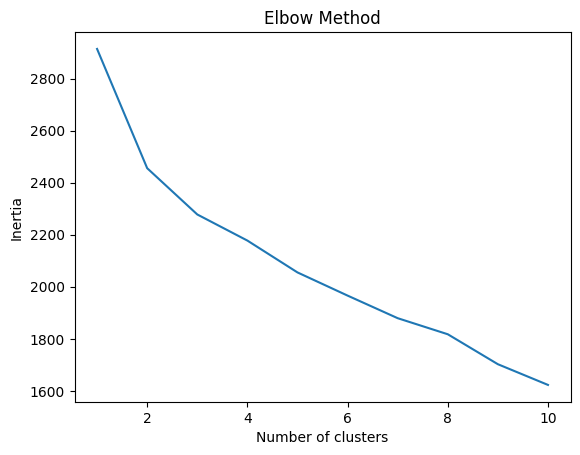

In [181]:
# elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [182]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(scaled_features)
all_members['cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [185]:
all_members[['twitter_name','cluster']].sort_values('cluster').to_csv('../../member_chapters/data/twitter_clusters_MARCH21.csv', index=False)